In [45]:
from tqdm import tqdm_notebook

In [13]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def teff_2_appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
#     def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
#         Inputs:
#         ------
#             best_fit_params: [array]
#             lit_age: [float] optional known literature age in Gyr
#             filename: [str] optional filename of plot if saving
#         '''
        
#         # initialize arrays
#         ages = np.arange(0,15,0.25)
#         theos = 999999.0*np.ones((len(ages),5))
#         theos_noext = 999999.0*np.ones((len(ages),5))
    
#         # calculate theoretical age for given ages
#         for j in range(len(ages)):
#             theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
#             theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for i in range(5):
#             ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
#             ax[i].plot(theos[:,i],ages)
            
#             ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
#             ax[i].plot(theos_noext[:,i],ages)
            
#             ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age!=None:
#                 ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
#             ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
#             ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
#             ax[i].set_ylim(bottom=0.01)
            
#             ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
#             ax[i].set_xlabel(r'Magnitude')
            
#         ax[0].legend()

#         ax[0].set_ylabel('Age')
        
#         if star_name!=None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
#                                                                           best_fit_params[1],self.distance))
        
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
#                                                                       self.distance))
    
#         if filename!=None:
#             plt.savefig(filename,bbox_inches='tight')
#         plt.show()
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags_age(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,17),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        self.age = age
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
    def get_mass(self,verbose=False):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        massdist = 999999.0*np.ones(nsamples)

        if self.age == 999999.0:
            return np.array([999999.0,999999.0])
        
        lgage = np.log10(self.age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]
                
                ### Use spline to find mass for a point in lgteffdist
                mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
                massdist[j] = mass_spl(np.log10(lgteffdist[j]))

                if verbose:
                    print('mass',mass_spl(np.log10(lgteffdist[j])))

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('mass: ',999999.0)   
                    massdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9

                mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
                mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(
                    np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

                massdist[j] = age_spl_interp(self.age)
            
        med_calc_mass = np.nanmedian(massdist)
        mad_calc_mass = self.mad(massdist)
        
        if np.isfinite(med_calc_mass)==False:
            med_calc_mass = 999999.0
        if np.isfinite(mad_calc_mass)==False:
            mad_calc_mass = 999999.0
        
        self.mass = med_calc_mass
        self.mass_err = mad_calc_mass
        
        mass_arr = np.array([med_calc_mass,mad_calc_mass])
        return mass_arr

    def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age
        
        Inputs:
        ------
            best_fit_age: best fit age in Gyr
            star_name: name of star
            lit_age: known literature age in Gyr
            filename: name of file if saving plot
        '''
        
        # intialize arrays
        ages = np.arange(0,15,0.25)
        theos_w_ext = 999999.0*np.ones((len(ages),5))
        theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
        # Calculate theoretical mags given an age in ages
        for i in range(len(ages)):
            theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
            theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for j in range(5):
            # with extinction
            ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
            ax[j].plot(theos_w_ext[:,j],ages)
            
            # without extinction
            ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
            ax[j].plot(theos_wo_ext[:,j],ages)
            
            ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age != None:
                ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
            ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
            ax[j].set_xlim(-14,14)
            ax[j].set_ylim(bottom=0.01)
            
            ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
            ax[j].set_xlabel(r'Magnitude')
        
        ax[0].legend()
        
        ax[0].set_ylabel('Age')
        
        if star_name != None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
                                                                          self.ak,self.distance))
            
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
                                                                      self.distance))
            
        if filename != None:
            plt.savefig(filename,bbox_inches='tight')
            
        plt.show()

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

In [3]:
### Geometry
def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [18]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_6.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

In [19]:
class test():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))

In [20]:
test_teff = np.array([4500,20])
test_abund = np.array([[-1.0,0.2],[0.02,0.02]]).T
test_obsphot = np.array([[11.0,12.75,13.0,13.25,13.5],[0.01,0.01,0.01,0.01,0.01]]).T
test_distance = 10000.

In [21]:
test(test_teff,test_abund,test_obsphot,test_distance,massive)

ValueError: min() arg is an empty sequence

In [24]:
salfeh = test_abund[0,0]+np.log10(0.655*(10**(test_abund[1,0]))+0.345)

iso = massive[np.where(massive['MH']==closest(massive['MH'],salfeh))]

uniq_ages = np.unique(massive['logAge'])

age_idx = []
for i in range(len(uniq_ages)):
    ages, = np.where(iso['logAge']==uniq_ages[i])
    age_idx.append(np.array([min(ages),max(ages)]))

age_idx = np.asarray(age_idx)

ValueError: min() arg is an empty sequence

In [25]:
np.where(iso['logAge']==uniq_ages[i])

(array([], dtype=int64),)

In [33]:
np.unique(massive['logAge'])

7.397939999999999
7.69897
7.87506
8.0
8.096910000000001
8.17609
8.243039999999999
8.30103
8.35218
8.39794
8.43933


In [32]:
np.unique(iso['logAge'])

7.397939999999999
7.69897
7.87506
8.0
8.096910000000001
8.17609
8.243039999999999
8.30103
8.35218
8.39794
8.43933


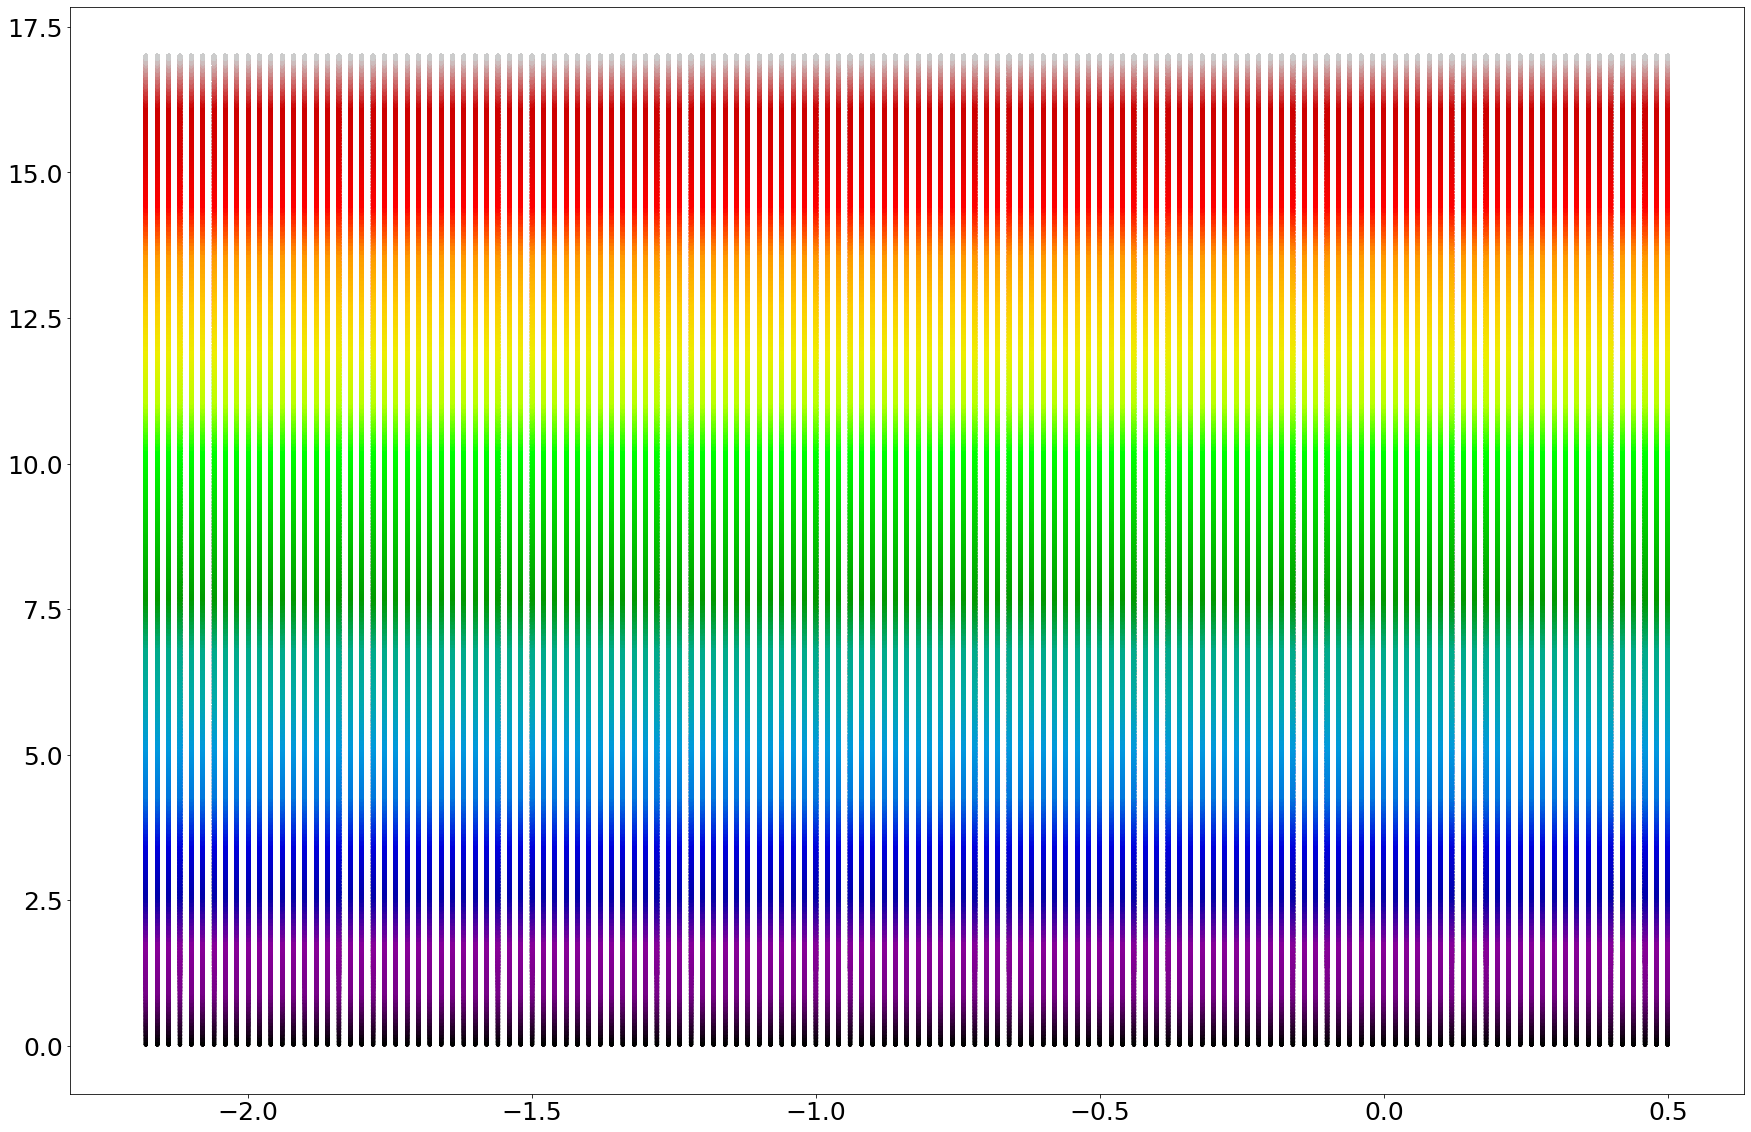

In [37]:
plt.figure(figsize=[30,20])
plt.scatter(massive['MH'],10**massive['logAge']/10**9,c=10**massive['logAge']/10**9,s=10,cmap='nipy_spectral')

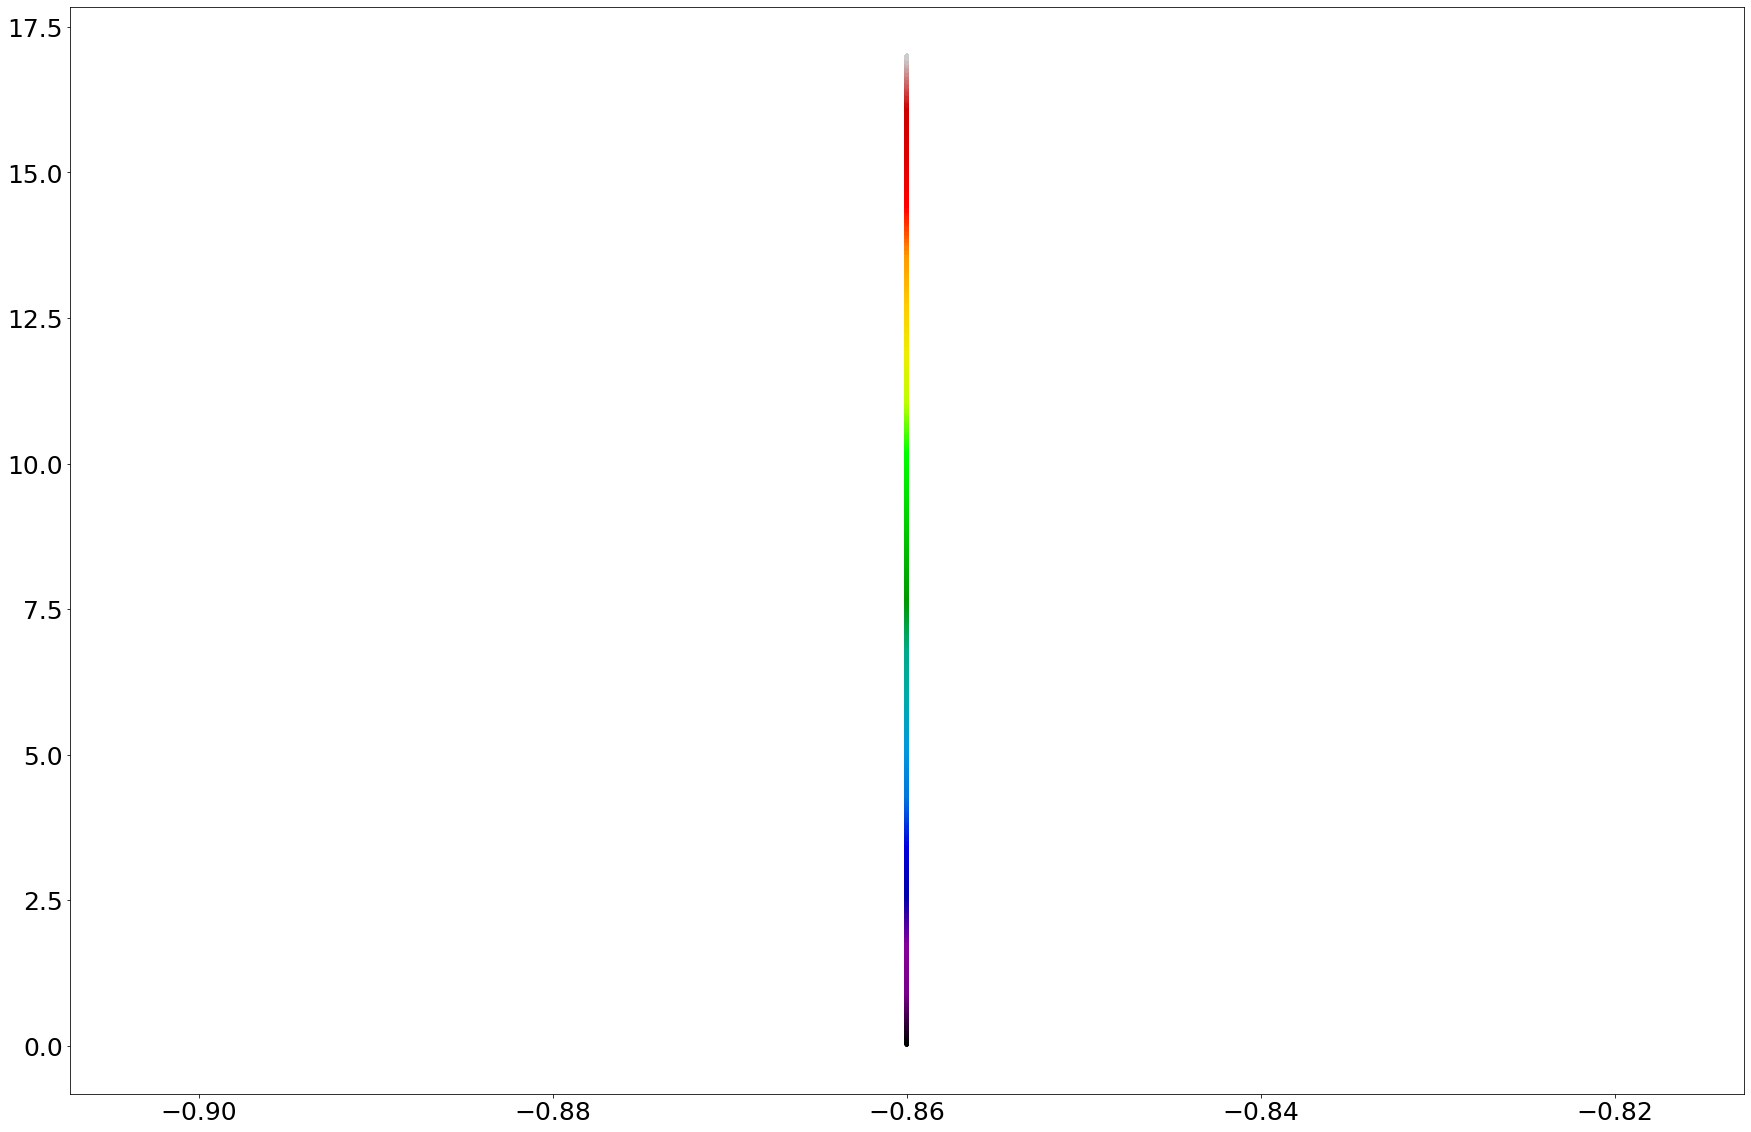

In [38]:
plt.figure(figsize=[30,20])
plt.scatter(iso['MH'],10**iso['logAge']/10**9,c=10**iso['logAge']/10**9,s=10,cmap='nipy_spectral')

In [46]:
inlist = []
for i in tqdm_notebook(range(len(np.unique(massive['logAge'])))):
    inwhere = np.where(np.unique(iso['logAge'])==np.unique(massive['logAge'])[i])
        
    if np.size(inwhere) == 0:
        inlist.append(0)
    else:
        inlist.append(1)

<ipython-input-46-56241be5c049>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.unique(massive['logAge'])))):


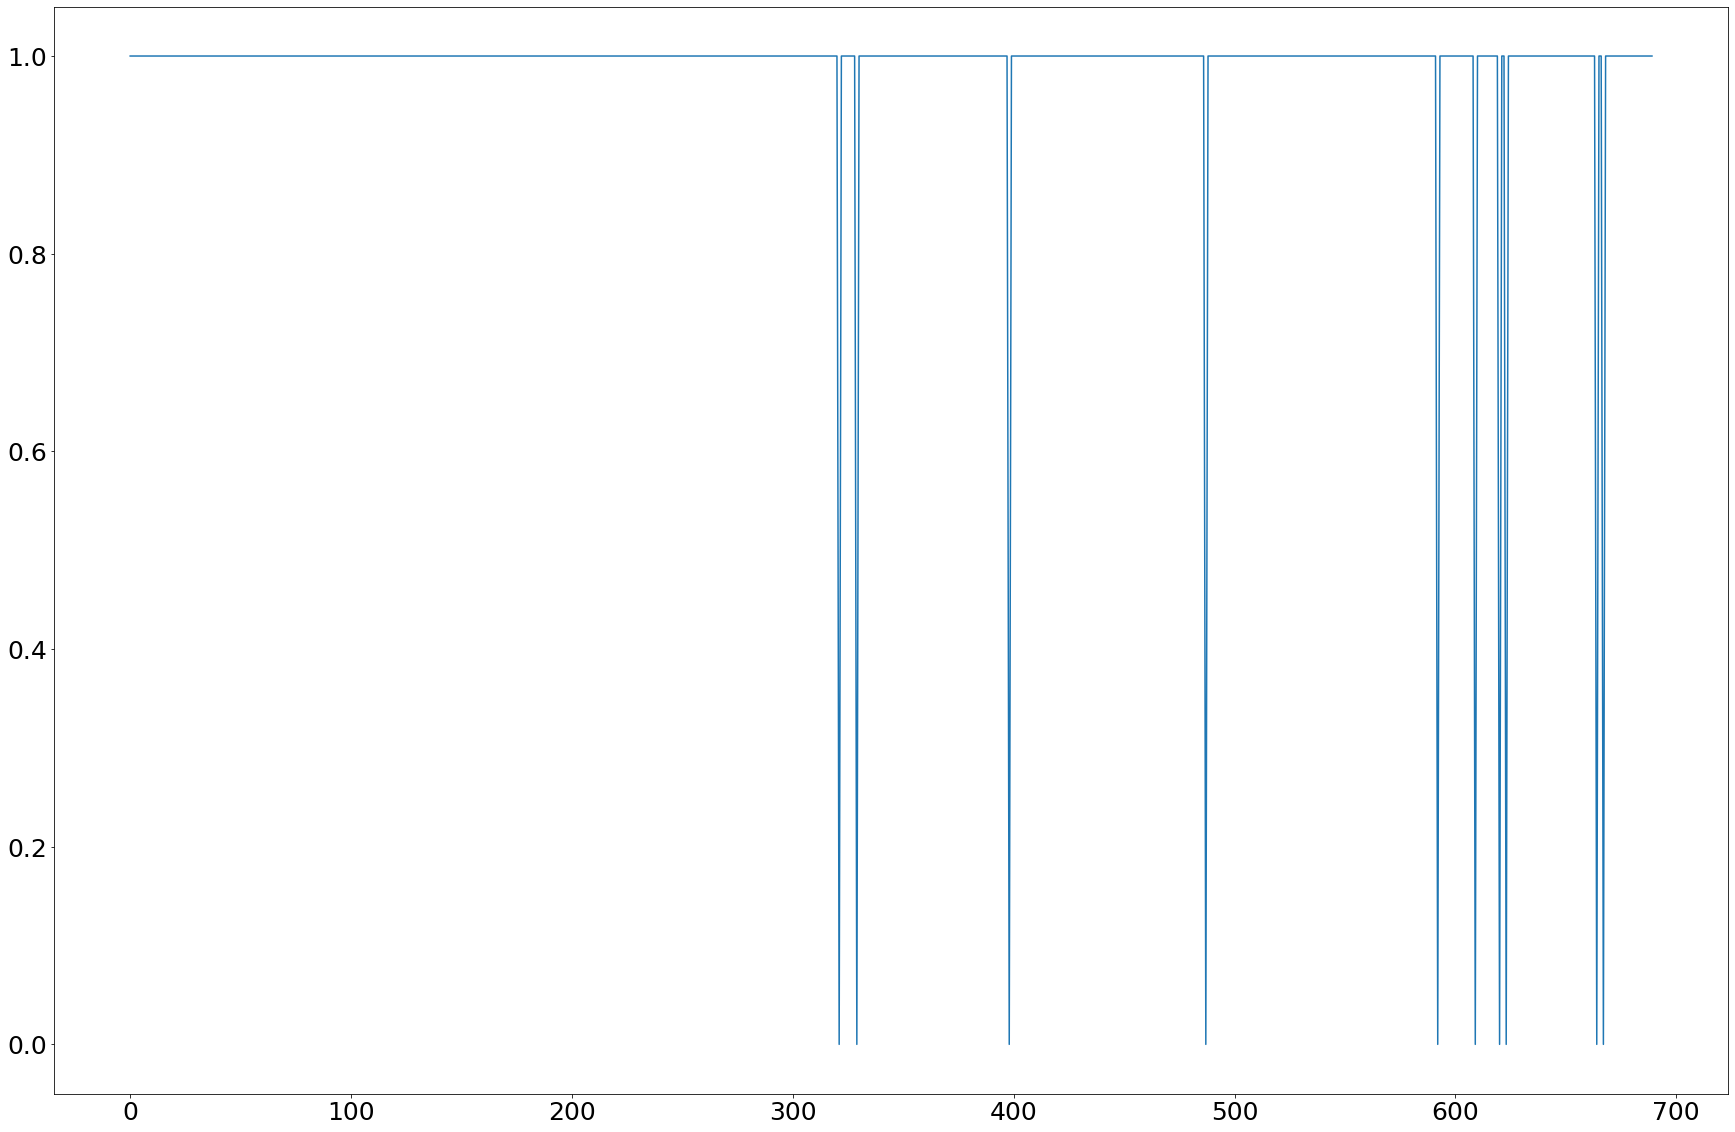

In [47]:
plt.figure(figsize=[30,20])
plt.plot(inlist)

In [50]:
10**np.unique(massive['logAge'])[np.where(np.asarray(inlist)==0)]/10**9

8.049891003356374
8.22488813664988
9.900109542601701
12.100128989595468
14.724820184316705
15.124812518275204
15.37481858412196
15.424816280180611
16.424796596746415
16.474794269202157


In [51]:
salfeh = test_abund[0,0]+np.log10(0.655*(10**(test_abund[1,0]))+0.345)

iso = massive[np.where(massive['MH']==closest(massive['MH'],salfeh))]

uniq_ages = np.unique(iso['logAge'])

age_idx = []
for i in range(len(uniq_ages)):
    ages, = np.where(iso['logAge']==uniq_ages[i])
    age_idx.append(np.array([min(ages),max(ages)]))

age_idx = np.asarray(age_idx)